<p style="font-size: 45px; text-align: center;"><b>Machine Learning in Finance II - final project</b></p>
<p style="font-size: 35px; text-align: center;"><b>Forecasting delays in delivery time - Brazilian E-commerce</b></p>
<p style="font-size: 20px; text-align: center;"><b>Summary - choosing the best model</b></p>

Author: Jakub Pyszniak

Summary Notebook

> **Here, we summarise the results of our modelling**

We utilise a similar custom RandomSearchCV set-up for cross-validation with some necessary modifications for each boosting model (especially for CatBoost due to slow performance) This ensures greater comparability of results however possibly ignores the full potential of indvidual tuning methods for each model

# Libraries

In [24]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from scipy import stats
import math
import time
from scipy.stats import randint, uniform, loguniform
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error
import seaborn as sns

# Visual set-up
pd.set_option("display.max_columns", 60)

# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor

# CatBoost
from catboost import Pool, cv, CatBoostRegressor

> Quick ranking:

1) CatBoost
2) XGBoost
3) LightGBM

**Bring the models**

In [2]:
def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def eval_reg(model, X_test, y_test):
    y_true = np.asarray(y_test).ravel()
    y_pred = model.predict(X_test)

    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae  = float(mean_absolute_error(y_true, y_pred))
    r2   = float(r2_score(y_true, y_pred))
    return rmse, mae, r2

In [9]:
xgb_model = load_pickle("5.models/xgb25_top9_final_model.pkl")
lgbm_model = load_pickle("5.models/lgbm10vars_final_model.pkl")
cb_model = load_pickle("5.models/catboost30vars_final_cb.pkl")

**And data**

In [5]:
X10_test = load_pickle("6.data_cache/X10_test.pkl")
X10_train = load_pickle("6.data_cache/X10_train.pkl")
X25_test_top9 = load_pickle("6.data_cache/X25_test_top9.pkl")
X25_train_top9 = load_pickle("6.data_cache/X25_train_top9.pkl")
X30_test = load_pickle("6.data_cache/X30_test.pkl")
X30_train = load_pickle("6.data_cache/X30_train.pkl")

y_test = load_pickle("6.data_cache/y_test.pkl")
y_train = load_pickle("6.data_cache/y_train.pkl")

# Best model

In [ ]:
results = {}

# XGBoost model was trained on "top9" feature set
results["XGBoost_top9"] = eval_reg(xgb_model, X25_test_top9, y_test)

# LightGBM model trained on 10-variable feature set
results["LightGBM_10vars"] = eval_reg(lgbm_model, X10_test, y_test)

# CatBoost model trained on your 30-variable feature set 
results["CatBoost_30vars"] = eval_reg(cb_model, X30_test, y_test) 

for name, (rmse, mae, r2) in results.items():
    print(f"{name}: RMSE={rmse:.5f} | MAE={mae:.5f} | R2={r2:.5f}")


XGBoost_top9: RMSE=7.14608 | MAE=5.10731 | R2=0.52361
LightGBM_10vars: RMSE=7.54629 | MAE=5.35523 | R2=0.46875
CatBoost_30vars: RMSE=7.10868 | MAE=5.01791 | R2=0.52858


> **We have the lowest RMSE for CatBoost!**

# Visual comparison

Let's take a quick glance at a comparison table of true and predicted target value

In [27]:
# predictions
y_pred_xgb  = xgb_model.predict(X25_test_top9)
y_pred_lgbm = lgbm_model.predict(X10_test)

cat_features = ["order_purchase_month", "order_delivery_month", "seller_state",
                "order_estimate_dow", "customer_state", "order_delivery_dow",
                "product_category_name_english", "order_purchase_dow"]
y_pred_cb = cb_model.predict(Pool(X30_test, cat_features=cat_features))

# comparison table
comp = pd.DataFrame({
    "y_true": np.asarray(y_test).ravel(),
    "XGBoost_pred": np.asarray(y_pred_xgb).ravel(),
    "LightGBM_pred": np.asarray(y_pred_lgbm).ravel(),
    "CatBoost_pred": np.asarray(y_pred_cb).ravel(),
})

print("Comp shape: ",comp.shape)
comp.head(20)

Comp shape:  (18295, 4)


,y_true,XGBoost_pred,LightGBM_pred,CatBoost_pred
0,-15.0,-11.234706,-15.767462,-15.813107
1,-2.0,-7.645432,-8.395748,-7.752098
2,-19.0,-17.676781,-19.722285,-18.782926
3,-17.0,-22.708967,-22.773411,-18.982039
4,-5.0,-7.863828,-8.323037,-7.831496
5,-3.0,-3.066820,-3.910100,-2.102483
6,-13.0,-16.062799,-16.588885,-17.238476
7,-19.0,-20.776369,-18.370669,-17.609615
8,-10.0,-9.123645,-12.827807,-11.544555
9,-20.0,-24.656822,-20.949879,-20.143409


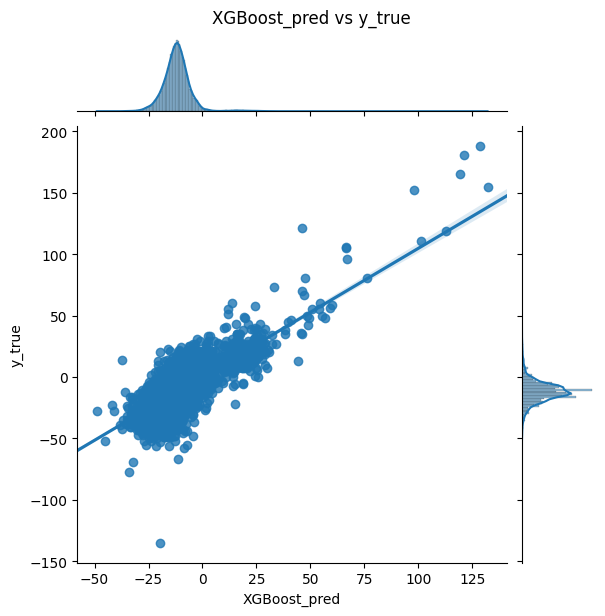

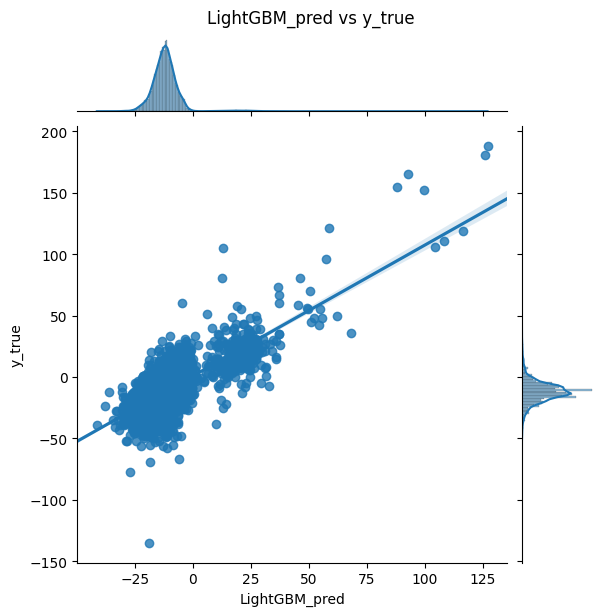

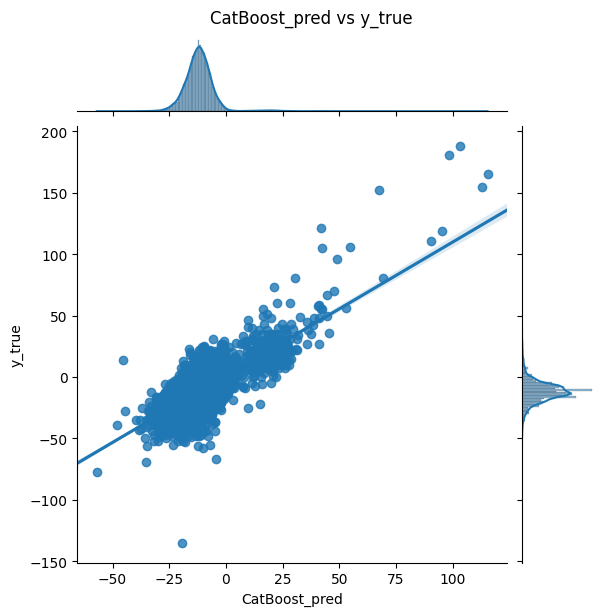

In [32]:
# comp columns: y_true, XGBoost_pred, LightGBM_pred, CatBoost_pred
pred_cols = ["XGBoost_pred", "LightGBM_pred", "CatBoost_pred"]

for col in pred_cols:
    g = sns.jointplot(
        data=comp,
        x=col,
        y="y_true",
        kind="reg",
        truncate=False
    )
    g.fig.suptitle(f"{col} vs y_true", y=1.02)  # title above plot
    g.set_axis_labels(col, "y_true")
    plt.show()

# Conclusions

> **CatBoost, despite its less complex parameter distribution grid for CV compared to other models, managed to achieve the best results (at the cost of computation time - great differences)**

This could have been partially due to the fact that some of the best variables from our Feature Ranking were categorical variables ("order_purchase_month", "order_delivery_month", "seller_state", "order_estimate_dow","customer_state", "order_delivery_dow", "product_category_name_english", "order_purchase_dow"). CatBoost's Target Encoding might have been useful in this situation.

**However, XGBoost was not weaker by a large margin.** For deployment purposes XGBoost might be the better option as in our case it was much faster than CatBoost. Spending the same amount of time on XGBoost's CV and HP tuning as we spent on CatBoost's CV might have yielded different results. The problem then, of course, is whether it is feasible and worthwhile to search through tens of optimal hyperparameters